In [4]:
''''
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Dense, InputLayer, Flatten
from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
''''

In [5]:
''''
img_width = 200
img_height = 200
img_folder = 'Covid\ClassifyDataset'
def create_dataset(img_folder):
    img_data_array = []
    class_name = []
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image_path = os.path.join(img_folder, dir1, file)
            image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (img_height, img_width), interpolation = cv2.INTER_AREA)
            image = np.array(image)
            image = image.astype('float32')
            image /=255
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name

img_data, class_name = create_dataset(img_folder)
''''

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
import random
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import Model

In [39]:
c = 'ClassifyDataset/COVID'
n = 'ClassifyDataset/Normal'
p = 'ClassifyDataset/Viral Pneumonia'

In [40]:
random.seed(42)
filenames = os.listdir(c) + random.sample(os.listdir(n), 5000) + os.listdir(p)

In [41]:
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append(str(2))
    elif category == 'Viral Pneumonia':
        categories.append(str(1))
    else:
        categories.append(str(0))

In [42]:
#Converting to dataframe
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    elif 'Viral Pneumonia' in filenames[i]:
        filenames[i] = os.path.join(p, filenames[i])
    else:
        filenames[i] = os.path.join(n, filenames[i])

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [43]:
df.head()

,filename,category
0,ClassifyDataset/COVID\COVID-1.png,2
1,ClassifyDataset/COVID\COVID-10.png,2
2,ClassifyDataset/COVID\COVID-100.png,2
3,ClassifyDataset/COVID\COVID-1000.png,2
4,ClassifyDataset/COVID\COVID-1001.png,2


In [20]:
pip install matplotlib==3.5.1

  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4
Note: you may need to restart the kernel to use updated packages.


AttributeError: module 'matplotlib.pyplot' has no attribute 'bar_label'

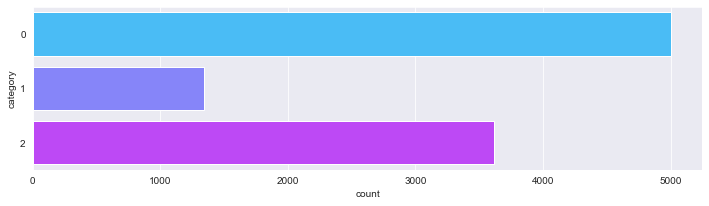

In [44]:
#Exploratory Data Analysis
plt.figure(figsize = (12,3))
splot = sns.countplot(data = df.sort_values(by = 'category'), y = 'category', palette='cool', saturation = 0.9)
plt.bar_label(container=splot.containers[0], labels=['Normal','COVID'], label_type='center', size=15, color='w')
plt.show()

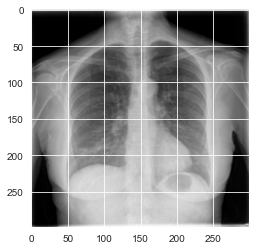

In [45]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)
plt.show()

In [46]:
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [47]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

In [48]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [49]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 7968 validated image filenames belonging to 3 classes.


In [50]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 997 validated image filenames belonging to 3 classes.


In [51]:
baseModel = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in baseModel.layers:
    layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(3, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

In [52]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [53]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
epochs = 50
history = model.fit(train_generator,validation_data=valid_generator, verbose=1, epochs=epochs)

Epoch 1/50
532/532 [==============================] - 2962s 6s/step - loss: 0.6085 - accuracy: 0.7428 - val_loss: 0.4143 - val_accuracy: 0.8275
Epoch 2/50
532/532 [==============================] - 2645s 5s/step - loss: 0.4311 - accuracy: 0.8252 - val_loss: 0.3558 - val_accuracy: 0.8636
Epoch 3/50
532/532 [==============================] - 2426s 5s/step - loss: 0.3811 - accuracy: 0.8507 - val_loss: 0.3014 - val_accuracy: 0.8937
Epoch 4/50
532/532 [==============================] - 2030s 4s/step - loss: 0.3483 - accuracy: 0.8623 - val_loss: 0.3025 - val_accuracy: 0.8867
Epoch 5/50
532/532 [==============================] - 2343s 4s/step - loss: 0.3310 - accuracy: 0.8670 - val_loss: 0.2985 - val_accuracy: 0.8857
Epoch 6/50
532/532 [==============================] - 2014s 4s/step - loss: 0.3118 - accuracy: 0.8717 - val_loss: 0.2487 - val_accuracy: 0.9168
Epoch 7/50
532/532 [==============================] - 2052s 4s/step - loss: 0.2982 - accuracy: 0.8799 - val_loss: 0.2513 - val_accuracy:

KeyboardInterrupt: 